To-Do: 
- Decoder layers to incorporate 4 hidden layers
- How to incorporate ROUGE metric into accuracy 
- research: how to save the models and keep them such that their training history + loss can be evaluated? 

In [1]:
# Import necessary packages 

import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import collections


/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-pack

In [2]:
# useful references: 
# https://github.com/PacktPublishing/Hands-On-Natural-Language-Processing-with-Python/blob/master/Chapter08/02_example.ipynb

## I. PreProcessing data 

In [3]:
sepdata = pd.read_csv('wikihowSep.csv', nrows = 10000)[['headline','text']] 

In [4]:
sepdata.head()
# We only care about 'headline' and 'text' 

,headline,text
0,\nSell yourself first.,"Before doing anything else, stop and sum up y..."
1,\nRead the classics before 1600.,Reading the classics is the very first thing ...
2,\nJoin online artist communities.,Depending on what scale you intend to sell yo...
3,\nMake yourself public.,Get yourself out there as best as you can by ...
4,\nBlog about your artwork.,"Given the hundreds of free blogging websites,..."


In [5]:
sepdata_v1 = sepdata.dropna(axis=0).reset_index(drop=True) 
# Get rid of any NA rows 

In [6]:
len(sepdata_v1)

9686

## Clean up of text

In [7]:
import re #for regex search purposes          
from nltk.corpus import stopwords #stopwords that are provided to us via nltk 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

In [8]:
# List of contractions that we will map to 

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [93]:
# Changes here: 
# Do not get rid of stopwords 
# Do not get rid of short words. 

def text_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: Lower case the text 
    newString = newString.lower()
    # Step 2: Get rid of commas
    newString = re.sub(r'\([^)]*\)', "", newString)
    # Step 3: Get rid of quotations 
    #newString = re.sub('"',"", newString)
    # Step 4: get rid of contractions with our contraction mapping 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # Step 5: get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    newString = re.sub(r"'s\b","",newString)
    # Step 6: anything that is a number, get rid of it 
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = newString.split()
    remaining = []
    for i in tokens: 
        if len(i)>=1: 
            remaining.append(i)
    # Step 7: Tokenize everything first and keep the words that are not stop words 
    # Also keep only words that are greater than or equal to 3 characters long 
    #tokens = [w for w in newString.split() if not w in stop_words]
    #long_words=[]
    #for i in tokens:
    #    if len(i)>=3: #removing short words
    #        long_words.append(i)   
    return (" ".join(remaining)).strip()

In [95]:
sepdata_v1['text'][20:25].apply(text_cleaner)[20]

'short stories are an incredible genre all their own and if you really want to be well read then you have to read the short stories of classic masters as well as some contemporary short stories for short stories it is more important to read the works of a particular author than a collection so here is a list of classic short story writers as well as more contemporary writers that you have to check out classic short story masters edgar allan poe anton chekhov ernest hemingway jorge luis borges kafka isaac babel john updike katherine mansfield eudora welty and ray bradbury contemporary short story masters flannery o connor raymond carver donald barthelme tim o brien george saunders jhumpa lahiri junot diaz z z packer joyce carol oates and denis johnson classic short story collections in our time by ernest hemingway a good man is hard to find by flannery o connor what we talk about when we talk about love by raymond carver jesus son by denis johnson interpreter of maladies by jhumpa lahir

In [96]:
# Changes here: 
# keep all words (previously, I got rid of words that were only 1 character long) 

def headline_cleaner(text):
    # Step 0: Convert to string in case a float or int is found.
    newString = str(text)
    # Step 1: remove quotations 
    newString = re.sub('"','', newString)
    # Step 2: look up contractions 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 
    # Step 3: Get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    newString = re.sub(r"'s\b","",newString)
    # Step 4: Get rid of numbers or anything not in the alphabet
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Step 5: Lower case 
    newString = newString.lower()
    tokens=newString.split()
    # Step 6: keep words that are greater than 1 character long 
    remaining=[]
    for i in tokens:
        if len(i)>=1:                                 
            remaining.append(i) 
    return (" ".join(remaining)).strip()

In [97]:
sepdata_v1['headline'][20:25].apply(headline_cleaner)[20]

'read short stories'

In [13]:
cleaned_data = sepdata_v1['text'].apply(text_cleaner) 

In [14]:
cleaned_y = sepdata_v1['headline'].apply(headline_cleaner)

In [15]:
clean_data = pd.concat([cleaned_data, cleaned_y], axis=1)
clean_data.columns = ['text','headline']

In [16]:
clean_data.head()

,text,headline
0,before doing anything else stop and sum up you...,sell yourself first
1,reading the classics is the very first thing y...,read the classics before
2,depending on what scale you intend to sell you...,join online artist communities
3,get yourself out there as best as you can by a...,make yourself public
4,given the hundreds of free blogging websites y...,blog about your artwork


In [17]:
#####
# Functions to build encoder and decoder embeddings later 
##### 

# Building top vocab 
def count_words(words_dict, text):
    for sentence in text:
        for word in sentence.split():
            if word not in words_dict:
                words_dict[word] = 1
            else:
                words_dict[word] += 1

def convert_text_to_ids(text, word2int_dict, eos=False): 
    # regular text (not summary)
    output = []
    for item in text:
        item2int=[]
        for word in item.split(): 
            if word in word2int_dict: 
                item2int.append(word2int_dict[word]) 
            else: 
                item2int.append(word2int_dict[TOKEN_UNK])
#        if eos: 
#            item2int.append(word2int_dict[TOKEN_EOS])
        output.append(item2int)
    return output

TOKEN_GO = '<GO>'
TOKEN_EOS = '<EOS>'
TOKEN_PAD = '<PAD>'
TOKEN_UNK = '<UNK>'
# These are special tokens 

def summary_convert_text_to_ids(text, word2int_dict): 
    # summaries only 
    output = []
    for item in text: 
        item2int = []
        for word in item.split(): 
            if word in word2int_dict: 
                item2int.append(word2int_dict[word])
            else: 
                item2int.append(word2int_dict[TOKEN_UNK])
        output.append([word2int_dict[TOKEN_GO]]+item2int+[word2int_dict[TOKEN_EOS]])
    return output
    

In [18]:
# Load pretrained embeddings and build word vector matrix 

def build_word_vector_matrix(vector_file):
    embedding_index = {}
    f = open(vector_file)
    for line in f: 
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32') 
        embedding_index[word] = coefs
    f.close() 
    return embedding_index

# Replace the path here to point to the glove.6B.50d.txt vectors file on your system
embeddings_index = build_word_vector_matrix('glove.6B.100d.txt')

In [19]:
len(embeddings_index)

400000

In [20]:
def text_to_seq(texts, MAX_NB_WORDS, EMBEDDING_DIM): 
    # -- Build word count dictionary: 
    word_counts_dict = {}
    count_words(word_counts_dict, texts) 
    print("Total words in Vocabulary:", len(word_counts_dict))
    
    # -- sort and return top MAX_NB_WORDS 
    sorted_x = sorted(word_counts_dict.items(), key=lambda kv: kv[1], reverse=True)
    sorted_dict_test = collections.OrderedDict(sorted_x)
    d = collections.Counter(sorted_dict_test)
    word_dict = dict(d.most_common(VOCAB_SIZE))
    
    # -- Build word to int dictionary 
    word2int = {} 
    value = 0
    #for word, count in word_dict.items(): 
    #    if word in embeddings_index: 
    #        word2int[word] = value
    #        value += 1
    special_codes = [TOKEN_UNK,TOKEN_PAD,TOKEN_EOS,TOKEN_GO]
    for code in special_codes:
        word2int[code] = len(word2int)
    value = 4 #force it to be 4 to be after our special tokens 
    for word, count in word_dict.items(): 
        if word in embeddings_index: 
            word2int[word] = value
            value+=1 
        
    # -- Build int to word dictionary 
    int2word = {}
    for word, value in word2int.items():
        int2word[value] = word
    
    # -- Build word_emb_matrix 
    word_emb_matrix = np.zeros((len(word2int), EMBEDDING_DIM), dtype=np.float32) 
    for word, i in word2int.items():
        if word in embeddings_index:
            # put in the embedding for the word 
            word_emb_matrix[i] = embeddings_index[word]
        else:
            # if word is not found, put in a random embedding 
            new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
            word_emb_matrix[i] = new_embedding
    print("Length of word embeddings: ", len(word_emb_matrix))
    

    # -- Finally, convert doc to the entire sequence 
    doc_as_ids = convert_text_to_ids(texts, word2int)
    return (doc_as_ids, word_emb_matrix, word2int, int2word)

In [21]:
def summary_text_to_seq(texts, MAX_NB_WORDS, EMBEDDING_DIM): 
    # -- Build word count dictionary: 
    word_counts_dict = {}
    count_words(word_counts_dict, texts) 
    print("Total words in Vocabulary:", len(word_counts_dict))
    
    # -- sort and return top MAX_NB_WORDS 
    sorted_x = sorted(word_counts_dict.items(), key=lambda kv: kv[1], reverse=True)
    sorted_dict_test = collections.OrderedDict(sorted_x)
    d = collections.Counter(sorted_dict_test)
    word_dict = dict(d.most_common(VOCAB_SIZE))
    
    # -- Build word to int dictionary 
    word2int = {} 
    value = 0
    #for word, count in word_dict.items(): 
    #    if word in embeddings_index: 
    #        word2int[word] = value
    #        value += 1
    special_codes = [TOKEN_UNK,TOKEN_PAD,TOKEN_EOS,TOKEN_GO]
    for code in special_codes:
        word2int[code] = len(word2int)
    value = 4 #start with 4 to force it to come after our tokens 
    for word, count in word_dict.items(): 
        if word in embeddings_index: 
            word2int[word] = value
            value+=1 
        
    # -- Build int to word dictionary 
    int2word = {}
    for word, value in word2int.items():
        int2word[value] = word
    
    # -- Build word_emb_matrix 
    word_emb_matrix = np.zeros((len(word2int), EMBEDDING_DIM), dtype=np.float32) 
    for word, i in word2int.items():
        if word in embeddings_index:
            # put in the embedding for the word 
            word_emb_matrix[i] = embeddings_index[word]
        else:
            # if word is not found, put in a random embedding 
            new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
            word_emb_matrix[i] = new_embedding
    print("Length of word embeddings: ", len(word_emb_matrix))
    
    # -- Finally, convert doc to the entire sequence 
    doc_as_ids = summary_convert_text_to_ids(texts, word2int)
    return (doc_as_ids, word_emb_matrix, word2int, int2word)

In [22]:
VOCAB_SIZE = 40000
embedding_dim = 100 

y_data, decoder_emb, y_word_index, y_index_word = summary_text_to_seq(clean_data['headline'], VOCAB_SIZE, embedding_dim)
X_data, encoder_emb, x_word_index, x_index_word = text_to_seq(clean_data['text'], VOCAB_SIZE, embedding_dim)
## make y_index_word 
## make x_index_word 
# (essentially reverse dictionary such that we can use this during inference)

Total words in Vocabulary: 6744
Length of word embeddings:  6586
Total words in Vocabulary: 18776
Length of word embeddings:  18011


In [23]:
y_word_index

{'<UNK>': 0,
 '<PAD>': 1,
 '<EOS>': 2,
 '<GO>': 3,
 'the': 4,
 'your': 5,
 'a': 6,
 'to': 7,
 'of': 8,
 'and': 9,
 'you': 10,
 'for': 11,
 'with': 12,
 'in': 13,
 'or': 14,
 'if': 15,
 'that': 16,
 'doctor': 17,
 'get': 18,
 'on': 19,
 'is': 20,
 'be': 21,
 'use': 22,
 'take': 23,
 'have': 24,
 'an': 25,
 'are': 26,
 'about': 27,
 'try': 28,
 'it': 29,
 'avoid': 30,
 'as': 31,
 'eat': 32,
 'consider': 33,
 'know': 34,
 'water': 35,
 'out': 36,
 'make': 37,
 'at': 38,
 'do': 39,
 'ask': 40,
 'from': 41,
 'can': 42,
 'keep': 43,
 'up': 44,
 'not': 45,
 's': 46,
 'any': 47,
 'understand': 48,
 'when': 49,
 'yourself': 50,
 'exercise': 51,
 'pregnancy': 52,
 'more': 53,
 'find': 54,
 'into': 55,
 'other': 56,
 'look': 57,
 'time': 58,
 'baby': 59,
 'talk': 60,
 'symptoms': 61,
 'pain': 62,
 'foods': 63,
 'will': 64,
 't': 65,
 'drink': 66,
 'what': 67,
 'day': 68,
 'check': 69,
 'diet': 70,
 'before': 71,
 'help': 72,
 'how': 73,
 'test': 74,
 'by': 75,
 'see': 76,
 'don': 77,
 'go': 78,
 

In [24]:
clean_data['headline']

0                        sell yourself first
1                   read the classics before
2             join online artist communities
3                       make yourself public
4                    blog about your artwork
                        ...                 
9681           have a culture test performed
9682                   take oral antibiotics
9683                      take hyaluronidase
9684        inject the area with antibiotics
9685    remove build up in the infected area
Name: headline, Length: 9686, dtype: object

In [25]:
y_data[0:5] #

[[3, 2780, 50, 114, 2],
 [3, 259, 4, 1801, 71, 2],
 [3, 576, 855, 2781, 3756, 2],
 [3, 37, 50, 2187, 2],
 [3, 3757, 27, 5, 3758, 2]]

In [28]:
encoder_emb.shape

(18011, 100)

In [29]:
len(x_word_index)

18011

In [30]:
decoder_emb.shape

(6586, 100)

In [31]:
len(y_word_index)

6586

In [32]:
max_text_length = 100 
max_summary_length = 30 
# https://stackoverflow.com/questions/51089903/preprocessing-for-seq2seq-model
# https://stackoverflow.com/questions/50662896/tensorflow-seq2seq-chatbot-always-give-the-same-outputs
# also note that keras truncates with 'pre' as the default 

def pad_text(textids_seq, x_word_index, max_text_length): 
    padded_text = np.zeros(shape=(len(textids_seq),max_text_length))
    for i in range(0, len(textids_seq)): 
        item = textids_seq[i]
        itemlen = len(item) 
        if itemlen<max_text_length: 
            # meaning, sequence is shorter than max_text_length 
            padded_text[i] = item + [x_word_index[TOKEN_PAD]]*(max_text_length-itemlen)
        else: 
            # meaning, sequence is longer than max_text_length 
            # There are multiple discussions on whether there should be EOS at the end, 
            # or if to just cut off the full text at the max text length 
            # If you cut off the full text at max text length, do we consider the default truncating of 'pre'? 
            padded_text[i] = item[:max_text_length]
    return(padded_text)

In [33]:
X_data_padded = pad_text(X_data, x_word_index, max_text_length)

In [34]:
X_data_padded[0][0]

69.0

In [35]:
x_index_word[X_data_padded[0][0]]

'before'

In [36]:
X_data_padded.shape

(9686, 100)

In [37]:
def pad_summary(summaryids_seq, y_word_index, max_summary_length): 
    padded_text = np.zeros(shape=(len(summaryids_seq),max_summary_length))
    for i in range(0, len(summaryids_seq)):
        #print(i)
        item = summaryids_seq[i] 
        itemlen = len(item) 
        if itemlen<max_summary_length: 
            padded_text[i] = item + [y_word_index[TOKEN_PAD]]*(max_summary_length - itemlen)
        else: 
            # EOS MUST be at the end 
            # Truncating happens at the front according to keras (with 'pre' set as default)
            padded_text[i] = item[(itemlen - max_summary_length):itemlen]
    return(padded_text)
            

In [38]:
y_data_padded = pad_summary(y_data, y_word_index, max_summary_length)

In [39]:
y_data_padded.shape

(9686, 30)

In [40]:
y_data_padded[232]

array([3.882e+03, 7.000e+00, 4.000e+00, 2.839e+03, 1.400e+01, 1.824e+03,
       1.000e+01, 2.400e+01, 1.200e+01, 1.585e+03, 2.000e+01, 2.840e+03,
       7.000e+00, 4.000e+00, 2.841e+03, 2.390e+02, 1.820e+02, 2.600e+01,
       1.559e+03, 7.000e+00, 7.800e+01, 7.000e+00, 1.440e+02, 2.000e+01,
       2.390e+02, 3.910e+02, 2.842e+03, 1.300e+01, 3.883e+03, 2.000e+00])

In [41]:
len(y_data[232])

34

In [ ]:
# Now to deal with padding 

# Arbitrary lengths decided by exploratory work...can change this later as we see fit 
##max_text_length = 100
#max_summary_length = 30

#def pad_sequences(textids_seq, summaryids_seq, x_word_index, y_word_index, max_text_length, max_summary_length): 
#    padded_text = []
#    for item in textids_seq: 
#        itemlen = len(item) 
#        if itemlen<max_text_length: 
#            # sequence is shorter than max_text_length 
#            padded_text.append(item + [x_word_index[TOKEN_PAD]]*(max_text_length - itemlen))
#        else: 
#            # sequence is longer than max_text_length 
#            #sublist = item[:(max_text_length-1)]
#            padded_text.append(item[:(max_text_length-1)] + [x_word_index[TOKEN_EOS]])
#    padded_summary = []
#    for item in summaryids_seq: 
#        itemlen = len(item)
#        if itemlen<max_summary_length: 
#            # sequence is shorter than max_summary_length 
#            padded_summary.append(item + [y_word_index[TOKEN_PAD]]*(max_summary_length - itemlen))
#        else: 
#            # sequence is longer than max_summary_length 
#            # also recall from previous: no EOS tag for summaries 
#            padded_summary.append(item[:(max_summary_length)])
#    return(np.array(padded_text), np.array(padded_summary))

#X_data_padded, y_data_padded = pad_sequences(X_data, y_data,x_word_index, y_word_index, max_text_length, max_summary_length)


In [ ]:
#X_data_padded[0]
#print(len(X_data_padded[0])) #!00 long

In [ ]:
#len(X_data_padded[0])

In [ ]:
#x_word_index[TOKEN_EOS] #note the EOS tag at the end 

In [ ]:
#y_data_padded[0]

In [ ]:
#y_data_padded[1]

In [ ]:
#y_word_index[TOKEN_PAD]

In [ ]:
#y_data_padded.shape

In [ ]:
#y_data_padded

In [42]:
# Input a split for train, CV, test 
from sklearn.model_selection import train_test_split

# Eventually here, we need to put in a test set that we do not touch 

x_train, x_test, y_train, y_test = train_test_split(X_data_padded, y_data_padded, test_size=0.2, 
                                                    random_state=0, shuffle = True)



In [43]:
len(x_train)

7748

In [44]:
len(x_test)

1938

## II. Build Model 

In [ ]:
# Note to self: Most of these, trying to stay as close to Vivek's model naming so we can compare 

In [53]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from attention_keras.layers.attention import AttentionLayer


from tensorflow.keras import backend as K 
K.clear_session() 

hidden_units = 200 #Paper mentions 600 hidden units, but we can change this 

In [54]:
enc_embedding_layer = Embedding(len(x_word_index),
                            embedding_dim,
                            weights=[encoder_emb],
                            input_length=max_text_length,
                            trainable=False,
                            name='EncoderEmbeddingLayer')

In [55]:
dec_embedding_layer = Embedding(len(y_word_index),
                            embedding_dim,
                            weights=[decoder_emb],
                            input_length=max_summary_length,
                            trainable=False,
                            name='DecoderEmbeddingLayer')

In [56]:
# Encoder 

# Encoder input 
# 2D (sequence_length, None), where sequence length is the MAX_LEN unified by padding in preprocessing
encoder_inputs = Input(shape=(max_text_length,), name="EncoderInput") 
enc_emb = enc_embedding_layer(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM1') 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM2') 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM3') 
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2) 

#LSTM 4 
encoder_lstm4=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM4') 
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)

In [57]:
# Decoder 

decoder_inputs = Input(shape=(None,), name = 'DecoderInput') 
#dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_embedding_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='DecLSTM1') 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

# dump in extra LSTM for decoders here 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(len(y_word_index)+1, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#decoder_outputs = TimeDistributed(Dense(len(y_word_index)+1, activation='softmax'))(decoder_concat_input) 
# should be same as above without renaming 'decoder_outputs'

In [58]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
EncoderEmbeddingLayer (Embeddin (None, 100, 100)     1801100     EncoderInput[0][0]               
__________________________________________________________________________________________________
EncLSTM1 (LSTM)                 [(None, 100, 200), ( 240800      EncoderEmbeddingLayer[0][0]      
__________________________________________________________________________________________________
EncLSTM2 (LSTM)                 [(None, 100, 200), ( 320800      EncLSTM1[0][0]                   
______________________________________________________________________________________________

In [59]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [60]:
#model.fit([X_data_padded[0:2000],y_data_padded[0:2000]], 
#                  y_data_padded[0:2000],
#                  epochs=1,
#                  batch_size=100)


# history=model.fit([x_tr,y_tr[:,:-1]],
# y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
# epochs=50,
# callbacks=[es],
# batch_size=512, 
# validation_data=([x_val,y_val[:,:-1]], 
# y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

# do a mini sample 
#x_mini_train = x_train[:5000] 
#y_mini_train = y_train[:5000]
#x_mini_test = x_test[:500] 
#y_mini_test = y_test[:500]

#history=model.fit([x_mini_train,np.hstack((np.zeros((y_mini_train.shape[0],1)), y_mini_train[:, :-1]))], 
#                  y_mini_train,
#                  epochs=2,
#                  batch_size=100, 
#                  validation_data=([x_mini_test,np.hstack((np.zeros((y_mini_test.shape[0],1)), y_mini_test[:, :-1]))], y_mini_test)
#                 )

history=model.fit([x_train,y_train[:,:-1]], 
                  y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
                  epochs=15,
                  batch_size=512, 
                  validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))


#history=model.fit([x_train,np.hstack((np.zeros((y_train.shape[0],1)), y_train[:, :-1]))], 
#                  y_train,
#                  epochs=1,
#                  batch_size=100, 
#                  validation_data=([x_test,np.hstack((np.zeros((y_test.shape[0],1)), y_test[:, :-1]))], y_test)
#                 )

Train on 7748 samples, validate on 1938 samples
Epoch 1/15
7748/7748 [==============================] - 195s 25ms/sample - loss: 5.1735 - val_loss: 2.0530
Epoch 2/15
7748/7748 [==============================] - 193s 25ms/sample - loss: 1.9261 - val_loss: 1.8367
Epoch 3/15
7748/7748 [==============================] - 202s 26ms/sample - loss: 1.7686 - val_loss: 1.7586
Epoch 4/15
7748/7748 [==============================] - 235s 30ms/sample - loss: 1.7056 - val_loss: 1.7170
Epoch 5/15
7748/7748 [==============================] - 223s 29ms/sample - loss: 1.6638 - val_loss: 1.6886
Epoch 6/15
7748/7748 [==============================] - 220s 28ms/sample - loss: 1.6361 - val_loss: 1.6713
Epoch 7/15
7748/7748 [==============================] - 220s 28ms/sample - loss: 1.6171 - val_loss: 1.6586
Epoch 8/15
7748/7748 [==============================] - 221s 29ms/sample - loss: 1.6021 - val_loss: 1.6496
Epoch 9/15
7748/7748 [==============================] - 221s 28ms/sample - loss: 1.5884 - val_lo

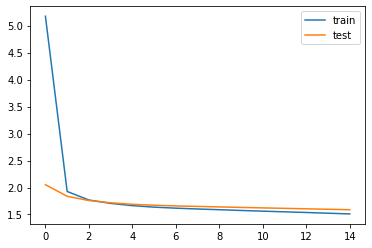

In [61]:
from matplotlib import pyplot 
%matplotlib inline
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [62]:
y_word_index['<EOS>']

2

In [63]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_hidden_state_input = Input(shape=(max_text_length,hidden_units))

# Get the embeddings of the decoder sequence
dec_emb2= dec_embedding_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)
#decoder_outputs2=TimeDistributed(Dense(len(y_word_index)+1, activation='softmax'))(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [64]:

# Edit this such that it deals with EOS 

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the '<GO>' word as the first word of the target sequence
    target_seq[0, 0] = y_word_index['<GO>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = y_index_word[sampled_token_index]

        if(sampled_token!='<EOS>'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == '<EOS>' or len(decoded_sentence.split()) >= (max_summary_length-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [65]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=y_word_index['<GO>']) and i!=y_word_index['<EOS>']):
            newString=newString+y_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+x_index_word[i]+' '
    return newString

In [78]:
for i in range(1900,1935):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_length)))
    print("\n")

Review: do not cut your toenails to follow the line of your toes as this can lead to ingrown toenails try not to cut them too short or leave them too long <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Original summary: cut your toenails straight across <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Predicted summary:  take your doctor <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Review: play relaxing music or use scents th

Predicted summary:  take your doctor <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Review: helping other people is obviously beneficial to those people but it also has many positive impacts on you helping other people can increase your level of happiness make you feel lucky to be who you are provide you with connections to other human beings make you feel needed and helpful reduce the amount of worrying you do and give you a sense of meaning or purpose to your life there is no shortage of charities and non profit organizations that need volunteers to help do just about any job you can think of but helping others doesn t have to 
Original summary: help others <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Predicted summary:  take your doctor <PAD> <PAD> <PAD> <PAD> <PA

Predicted summary:  take your doctor <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Review: tree stumps that haven t been fully removed can collect standing water that may not be readily apparent instead of allowing a stump to slowly decompose continue chopping it until you can till it into the surrounding soil or remove it entirely <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Original summary: remove stumps <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Predicted summar

Predicted summary:  take your doctor <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Review: many smokers find the left over smoke stale and prefer not to smoke it instead blow lightly through the to force the remaining stem up and out the mouthpiece of the bong do not ever exhale back into the top of a bong as this usually spills the water out the or carb and can wet the bowl ruining any extra smoking material <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Original summary: clear any remaining smoke from the water bong before passing it on <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
Predicted summary:  take your doctor <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

In [75]:
seq2text(x_test[80])

'make sure you drink several glasses of water before you exercise you can also have a water bottle close by so you can take small sips of water while you exercise then have several more glasses of water after you are done exercising to ensure you stay hydrated if you experience any signs of dehydration such as dizziness a racing heart and urine that is dark yellow while working out drink water right away if you aren t into drinking plain water add fresh lemon or lime slices to your water to help you drink more of it you may '

In [77]:
len(x_test)

1938

85